In [6]:
import mysql.connector as connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [70]:
# connexion au serveur admen
# Lecture des tables admen
# Lecture des societes propres

mydb = connection.connect(user = 'hhamdi', database = 'admen', host = '10.1.10.13', port = 3306, password = 'Nop6767pop',use_pure=True)            
query_societes_a_garder = "select *  from societes where \
                               ( id_societe in  ( select s.id_societe from societes s \
                                                  inner join personnes p on s.id_societe = p.id_societe)) \
                          OR   (id_societe in   ( select s.id_societe from societes s \
                                                  inner join actions a on s.id_societe = a.id_societe \
                                                  where subdate(Date(Now()), INTERVAL 5 year) <= a.date_prevue)) \
                          OR   ( id_societe in  ( select s.id_societe from societes s \
                                                  inner join missions m on s.id_societe = m.id_societe \
                                                  inner join facturation f on m.id_mission = f.id_mission ))" 

# rajouter delete from societe where id_societe not in () pour la suppression des societes concernées
societes_maj = pd.read_sql(query_nettoyage_societes, mydb)   # resultat sous forme dataframe

# mydb.close() #close the connection

In [ ]:
# Lecture des tables societes, missions, actions, personnes
query_societes = "Select * from societes;"
query_missions = "Select * from missions;"
query_actions = "Select * from actions;"
query_personnes = "Select * from personnes;"

societes = pd.read_sql(query_societes,mydb)
missions = pd.read_sql(query_missions,mydb)
actions = pd.read_sql(query_actions,mydb)
personnes = pd.read_sql(query_personnes,mydb)

#tables = [societes,missions, actions,personnes]
#queries = [query_societes,query_missions, query_actions, query_personnes]

In [11]:
# Affichage premiéres lignes
societes_maj.head()

,ID_SOCIETE,ID_SIEGE,RAISON_SOCIALE,ADRESSE,CODE_POSTAL,VILLE,TEL,FAX,PROFIL,CODE_NAF,...,LIST2,LASTUSERACTION,NUMVAT,RAISON_SOCIALE2,AWA2COMPANYREF,CSIGN,POSTIT,DATE_MAJ,INDEXED,PAYMENT_LIMIT
0,1,0,LINCOLN,,None,None,None,None,0,,...,None,PERNOTTE Marion,None,,,,None,2021-10-18 13:47:18,1,None
1,14,0,CHEMUNEX SA,None,None,None,None,None,0,,...,None,ANCIENS CR,None,,,,None,2018-04-23 17:39:30,1,None
2,15,0,BOUYGUES TELECOM,"83, rue Henri Farman",92130,Issy Les Moulineaux,01 39 26 75 00,01 39 26 75 01,0,28,...,,DE WATRIGANT Véronique,None,BOUYGUES TELECOM,,BOUYGUES TELECOM,,2021-10-19 16:49:01,1,None
3,18,0,ACXIOM,"235, avenue le Jour se Lève",92100,BOULOGNE,None,None,0,,...,None,PUJOS Maria,None,,,,None,2018-07-05 14:36:43,1,None
4,20,0,ORANGE,"78, rue Olivier de Serres",75015,Paris,01 44 44 22 22,,0,642C,...,,BIGATA Carmen,None,ORANGE,,ORANGE,,2021-10-26 18:12:13,1,None


In [12]:
# Dimension des données
societes_maj.shape

(28602, 86)

In [13]:
# informations sur les données
societes_maj.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28602 entries, 0 to 28601
Data columns (total 86 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_SOCIETE          28602 non-null  int64         
 1   ID_SIEGE            28602 non-null  int64         
 2   RAISON_SOCIALE      28602 non-null  object        
 3   ADRESSE             24338 non-null  object        
 4   CODE_POSTAL         27965 non-null  object        
 5   VILLE               27994 non-null  object        
 6   TEL                 25319 non-null  object        
 7   FAX                 21784 non-null  object        
 8   PROFIL              28602 non-null  int64         
 9   CODE_NAF            28602 non-null  object        
 10  SIRET_SIREN         28602 non-null  object        
 11  NUM_ORG_FORM        18716 non-null  object        
 12  LIBRE_1             27846 non-null  object        
 13  LIBRE_2             21309 non-null  object    

<BarContainer object of 86 artists>

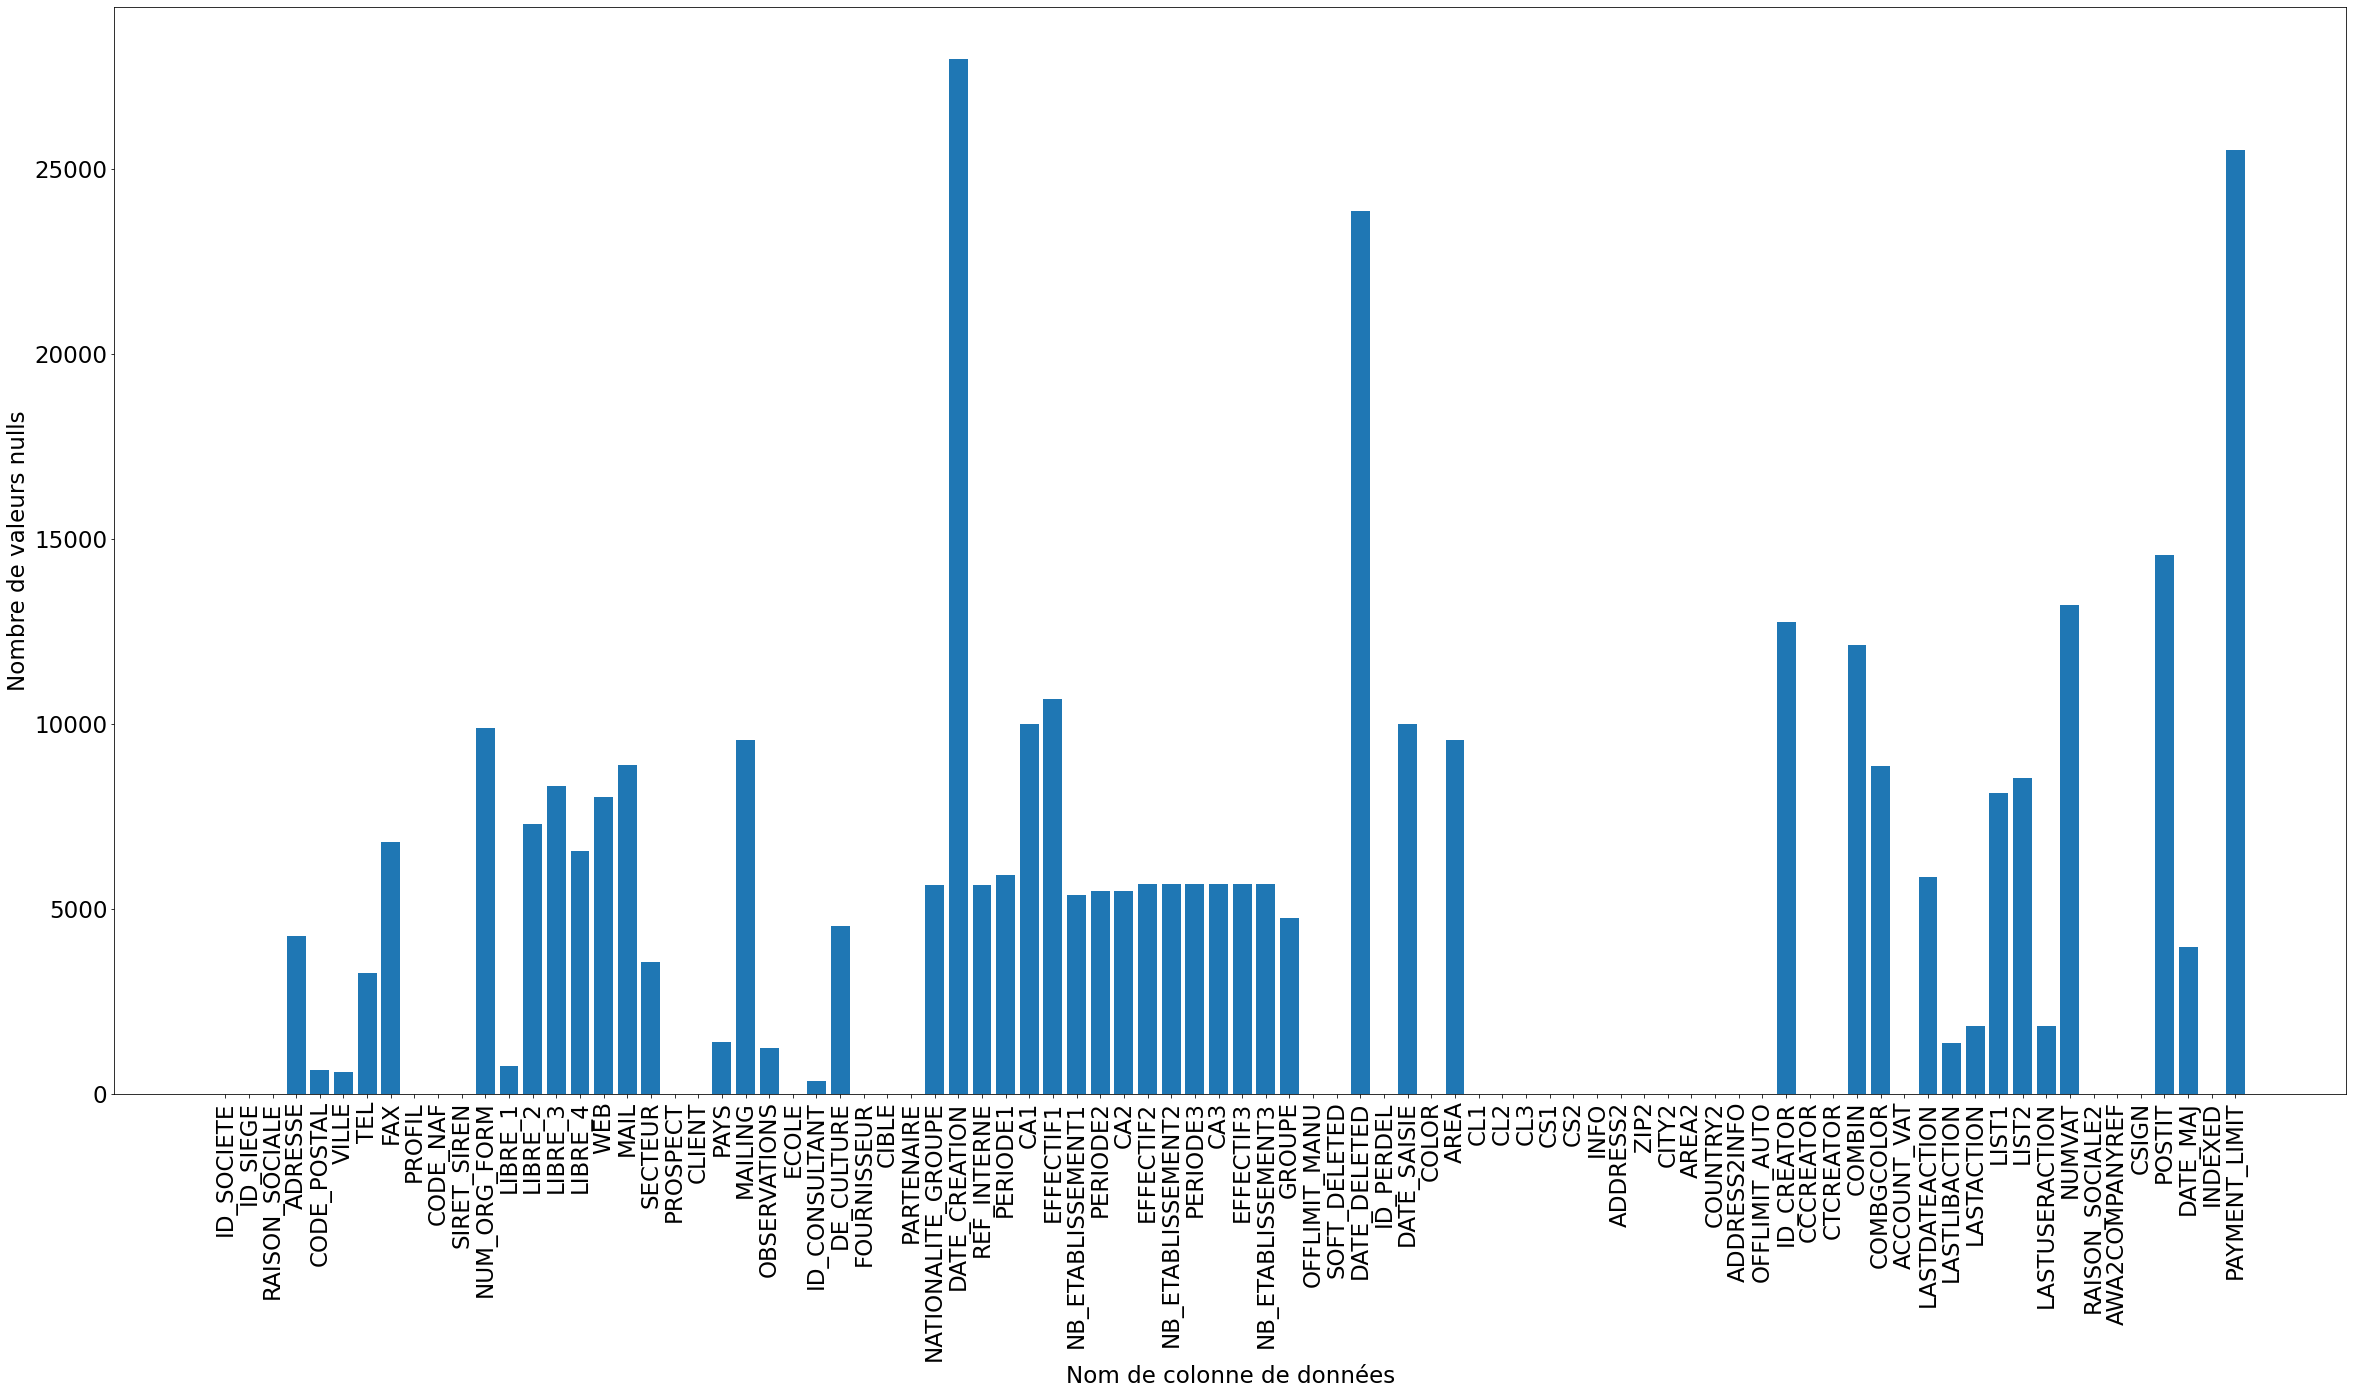

In [67]:
# Distribution des valeurs nuls par colonne
distribution_null = societes_maj.isnull().sum().to_frame().reset_index().rename(columns = {'index':'colonne', 0:'Sum_valeurs_null'})
plt.figure(figsize = (40,20))
plt.xticks(rotation='vertical', fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Nom de colonne de données', fontsize = 23)
plt.ylabel('Nombre de valeurs nulls', fontsize = 23)
plt.bar(distribution_null['colonne'],distribution_null['Sum_valeurs_null'])


<AxesSubplot:>

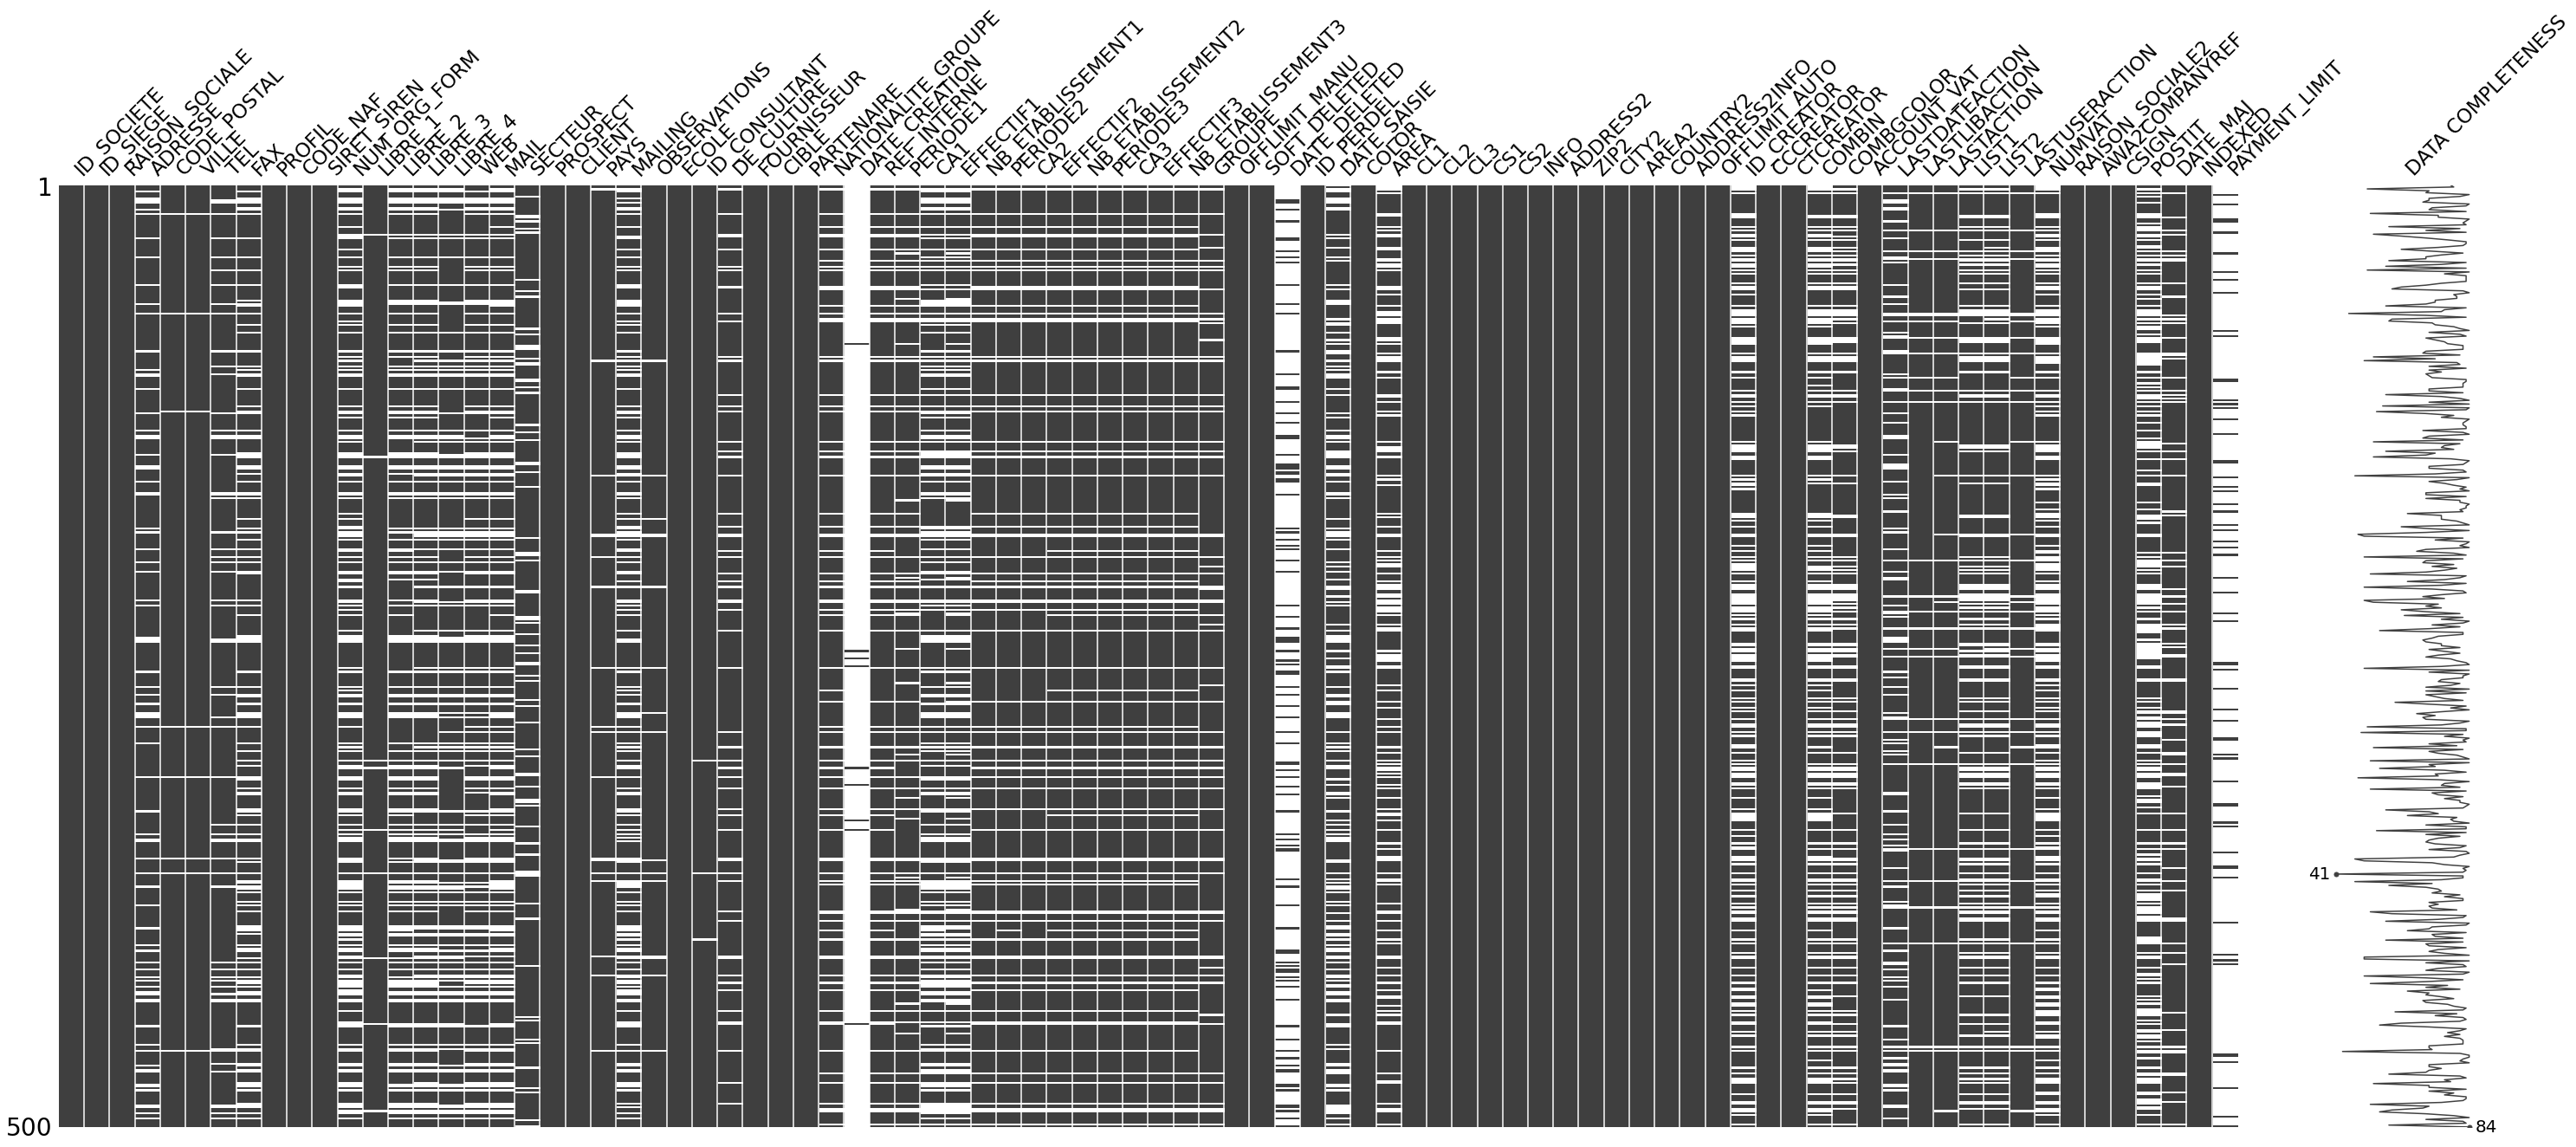

In [39]:
# Visuaisation de la distribution des valeurs nuls des données
import missingno as msno
msno.matrix(societes_maj.sample(500), labels=True,  figsize=(50, 20), fontsize = 23)

In [40]:
# Drop duplicates
initial_length = len(societes_maj)
societes_maj.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(societes_maj)))

Suppression des doublons: 0


In [54]:
# construire une fonction Missing assessment pour présenter le pourcentage des valeurs NaN de maniére décroissant
# arbitrage sur les lignes ou colonnes à retirer (exemple colonne avec plus de 30% de valeurs null)
def missing_values_assessment(df):
    nan_values = df.isnull().sum().sum()
    print('Nombre d\'observations: {:,}'.format(len(df.index)))
    print('Nombre de valeurs: {:,}'.format(df.size))
    print('Valeurs manquantes: {:,}'.format(nan_values))
    print('Qualité des données: {}%'.format(100-round((nan_values/df.size)*100,2)))
    print('Type de données:\n {}%'.format(df.dtypes.value_counts()))
    analysis = {'Manquant': df.isnull().sum(),
                'Manquant %':round((df.isnull().sum()/len(df))*100, 2),
                'Type':df.dtypes
               }
    return pd.DataFrame(analysis)

In [61]:
missing_values_assessment(societes_maj).sort_values('Manquant %', ascending=False)

Nombre d'observations: 28,602
Nombre de valeurs: 2,459,772
Valeurs manquantes: 369,132
Qualité des données: 84.99%
Type de données:
 object            60
int64             15
float64            9
datetime64[ns]     2
dtype: int64%


,Manquant,Manquant %,Type
DATE_CREATION,27982,97.83,object
PAYMENT_LIMIT,25509,89.19,object
DATE_DELETED,23859,83.42,object
POSTIT,14555,50.89,object
NUMVAT,13223,46.23,object
...,...,...,...
INFO,0,0.00,object
ADDRESS2,0,0.00,object
ZIP2,0,0.00,object
CITY2,0,0.00,object


In [ ]:
#enrechissement des données societes


In [62]:
# Lecture de la table missions
query_missions = "Select * from missions;"
missions = pd.read_sql(query_missions,mydb)

In [127]:
# Lecture de la table actions
mydb = connection.connect(user = 'hhamdi', database = 'admen', host = '10.1.10.13', port = 3306, password = 'Nop6767pop',use_pure=True)            
query_actions = "Select * from actions;"
actions = pd.read_sql(query_actions,mydb)

In [64]:
# Lecture de la table personnes
query_personnes = "Select * from personnes;"
personnes = pd.read_sql(query_personnes,mydb)

# Etude Table missions

In [78]:
# view détails table missions
missions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Columns: 121 entries, ID_MISSION to ID_ISO_CURRENCY
dtypes: datetime64[ns](1), float64(28), int64(31), object(61)
memory usage: 17.5+ MB


In [79]:
# view premiéres lignes table missions
missions.head()

,ID_MISSION,ID_SOCIETE,ID_CONSULTANT,REF_INTERNE,LIBELLE,NB_RECRUT,DESC_MISSION,DATE_PROPOSITION,MONTANT,ETAT,...,CAC_FILTER,CAC_PERS1_ACCESS,CAC_PERS2_ACCESS,CAC_PERS3_ACCESS,CAC_PERS4_ACCESS,CAC_ACCESS,CAC_SHOW_DOC,EASYRECRUECAMPAIGNID,ASSESSFIRSTID,ID_ISO_CURRENCY
0,5,71023,11,MB.FCJ.CHAFF,HEWLETT PACKARD Chargé D'affaires - Financial ...,0.0,,None,NaN,2,...,100000000000000,NaN,NaN,NaN,NaN,0,0,0,0,None
1,6,71023,11,MB.FIS03,HEWLETT PACKARD Consultant Douanes,0.0,,None,NaN,2,...,000000000000000,0.0,0.0,0.0,0.0,0,0,0,0,None
2,7,20,11,MB.CONS05,FRANCE TELECOM Consolideur,0.0,,None,NaN,2,...,000000000000000,0.0,0.0,0.0,0.0,0,0,0,0,None
3,8,71023,11,MB.FIS01,HEWLETT PACKARD Directeur Fiscal,0.0,,None,NaN,2,...,000000000000000,0.0,0.0,0.0,0.0,0,0,0,0,None
4,9,71023,11,MB.EXCO,DFM Directeur de Mission Futur Associé,0.0,,None,NaN,2,...,000000000000000,0.0,0.0,0.0,0.0,0,0,0,0,None


<BarContainer object of 121 artists>

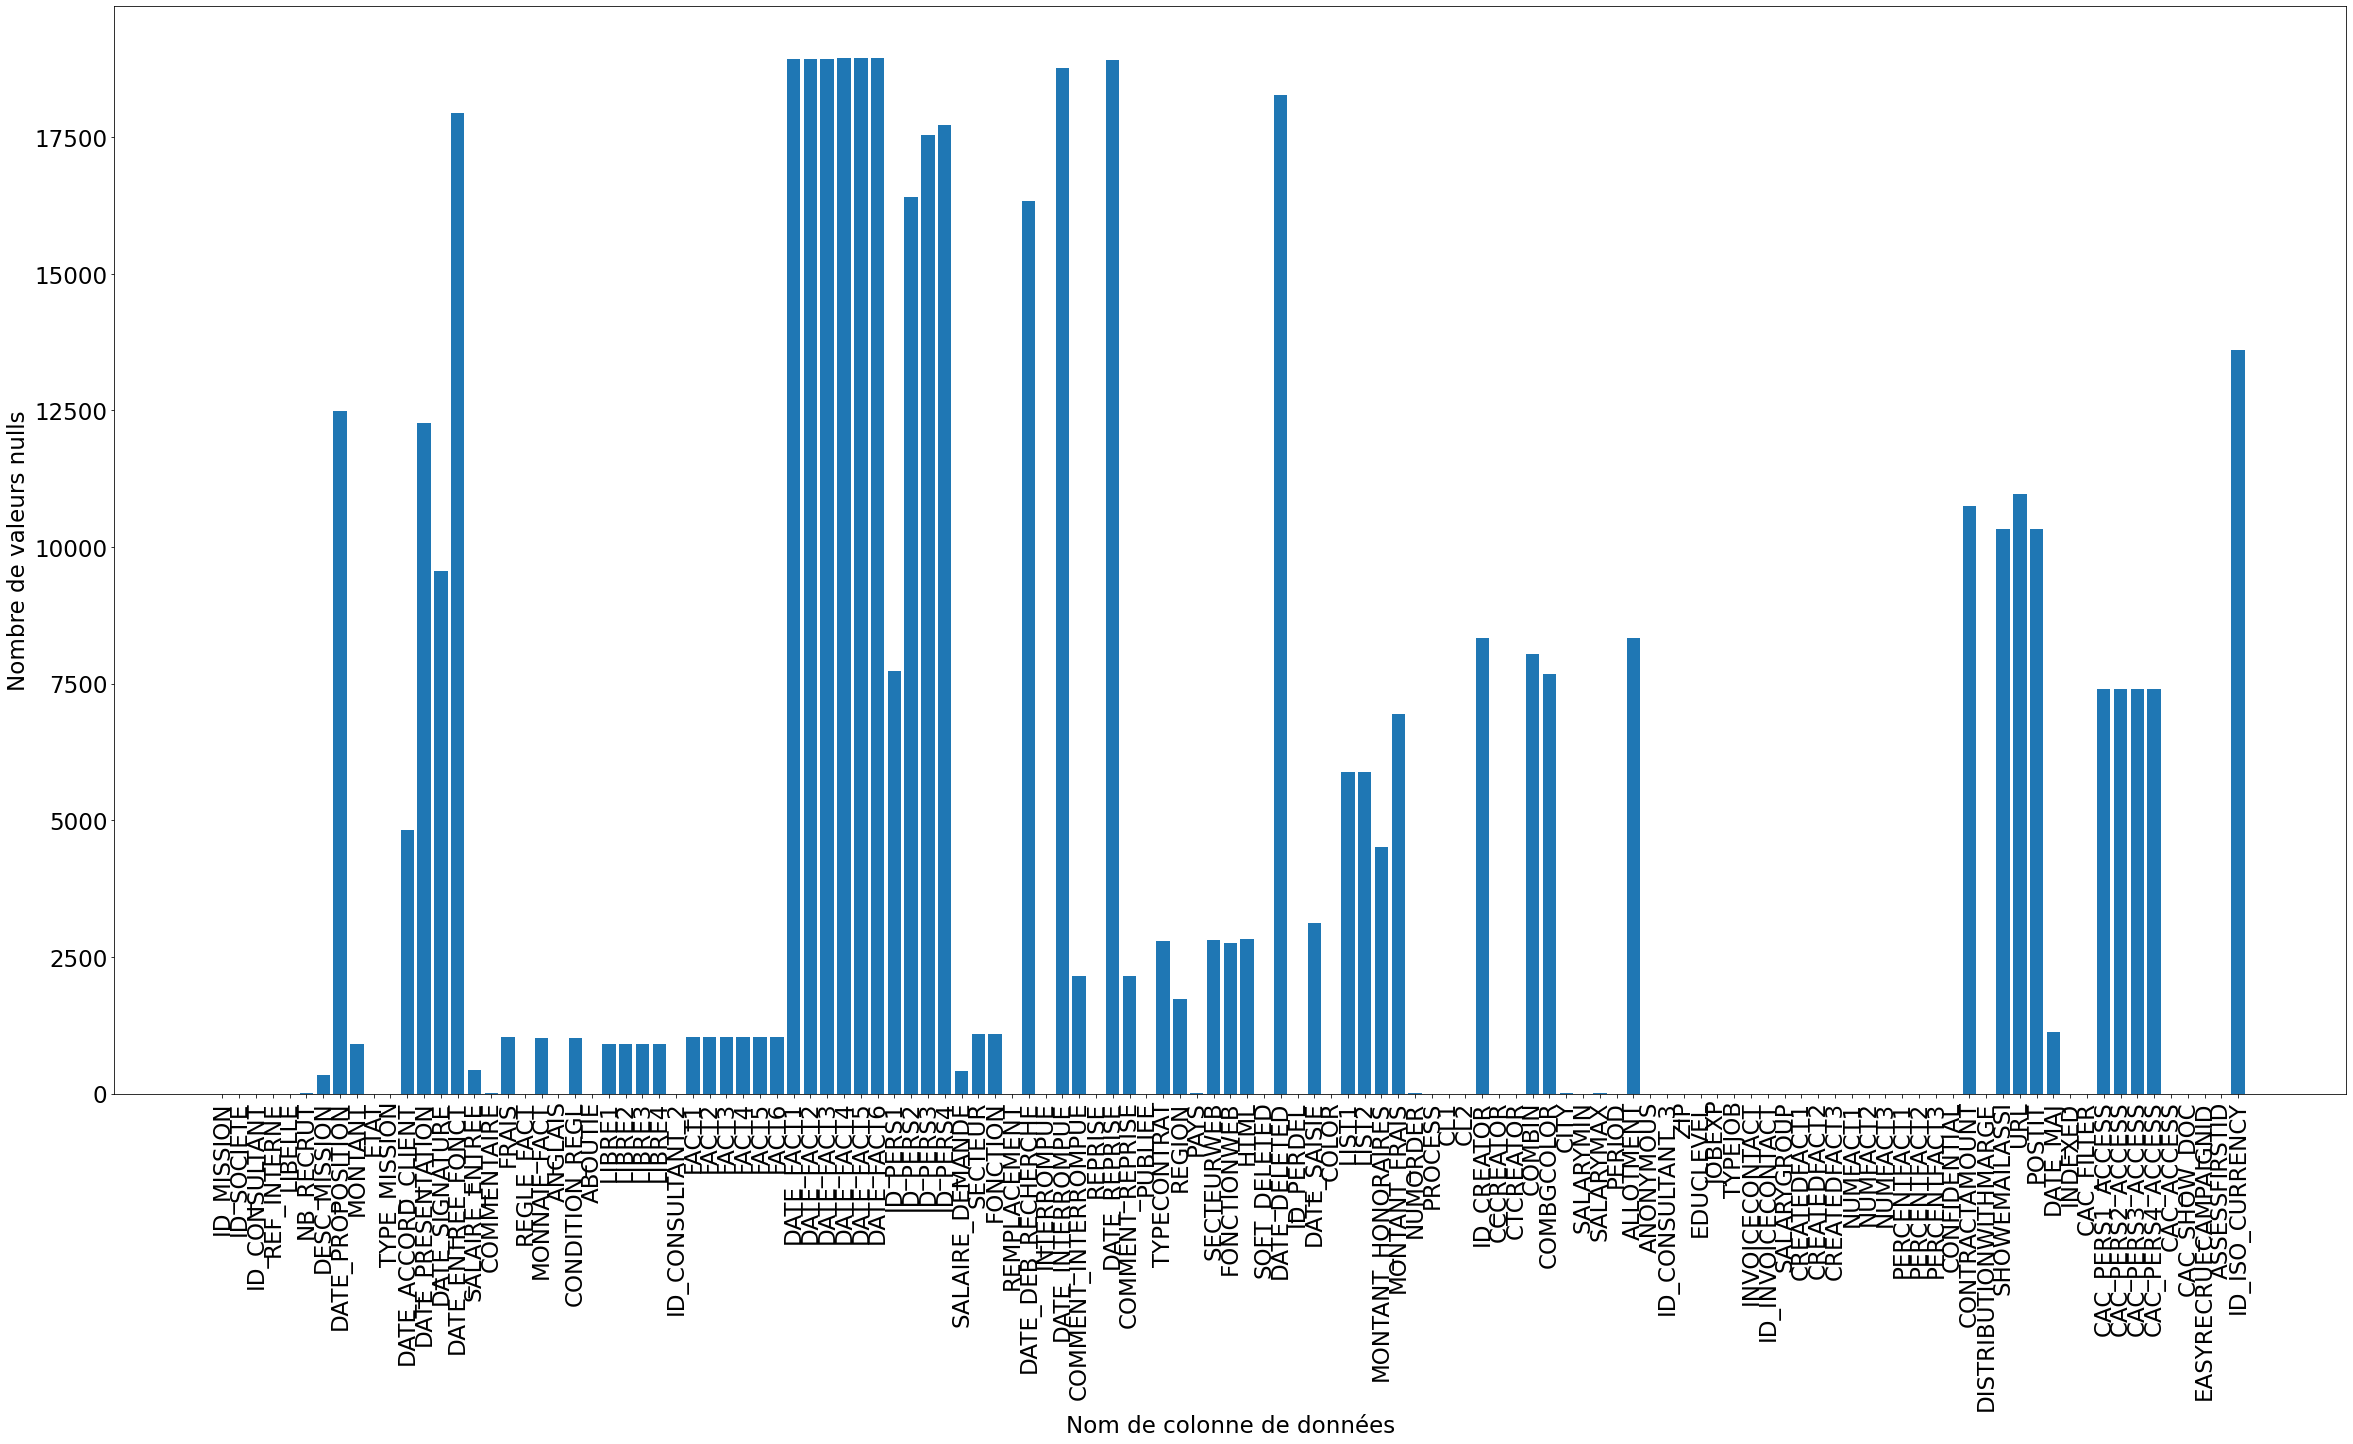

In [80]:
# Distribution des valeurs nuls par colonne
distribution_null = missions.isnull().sum().to_frame().reset_index().rename(columns = {'index':'colonne', 0:'Sum_valeurs_null'})
plt.figure(figsize = (40,20))
plt.xticks(rotation='vertical', fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Nom de colonne de données', fontsize = 23)
plt.ylabel('Nombre de valeurs nulls', fontsize = 23)
plt.bar(distribution_null['colonne'],distribution_null['Sum_valeurs_null'])

<AxesSubplot:>

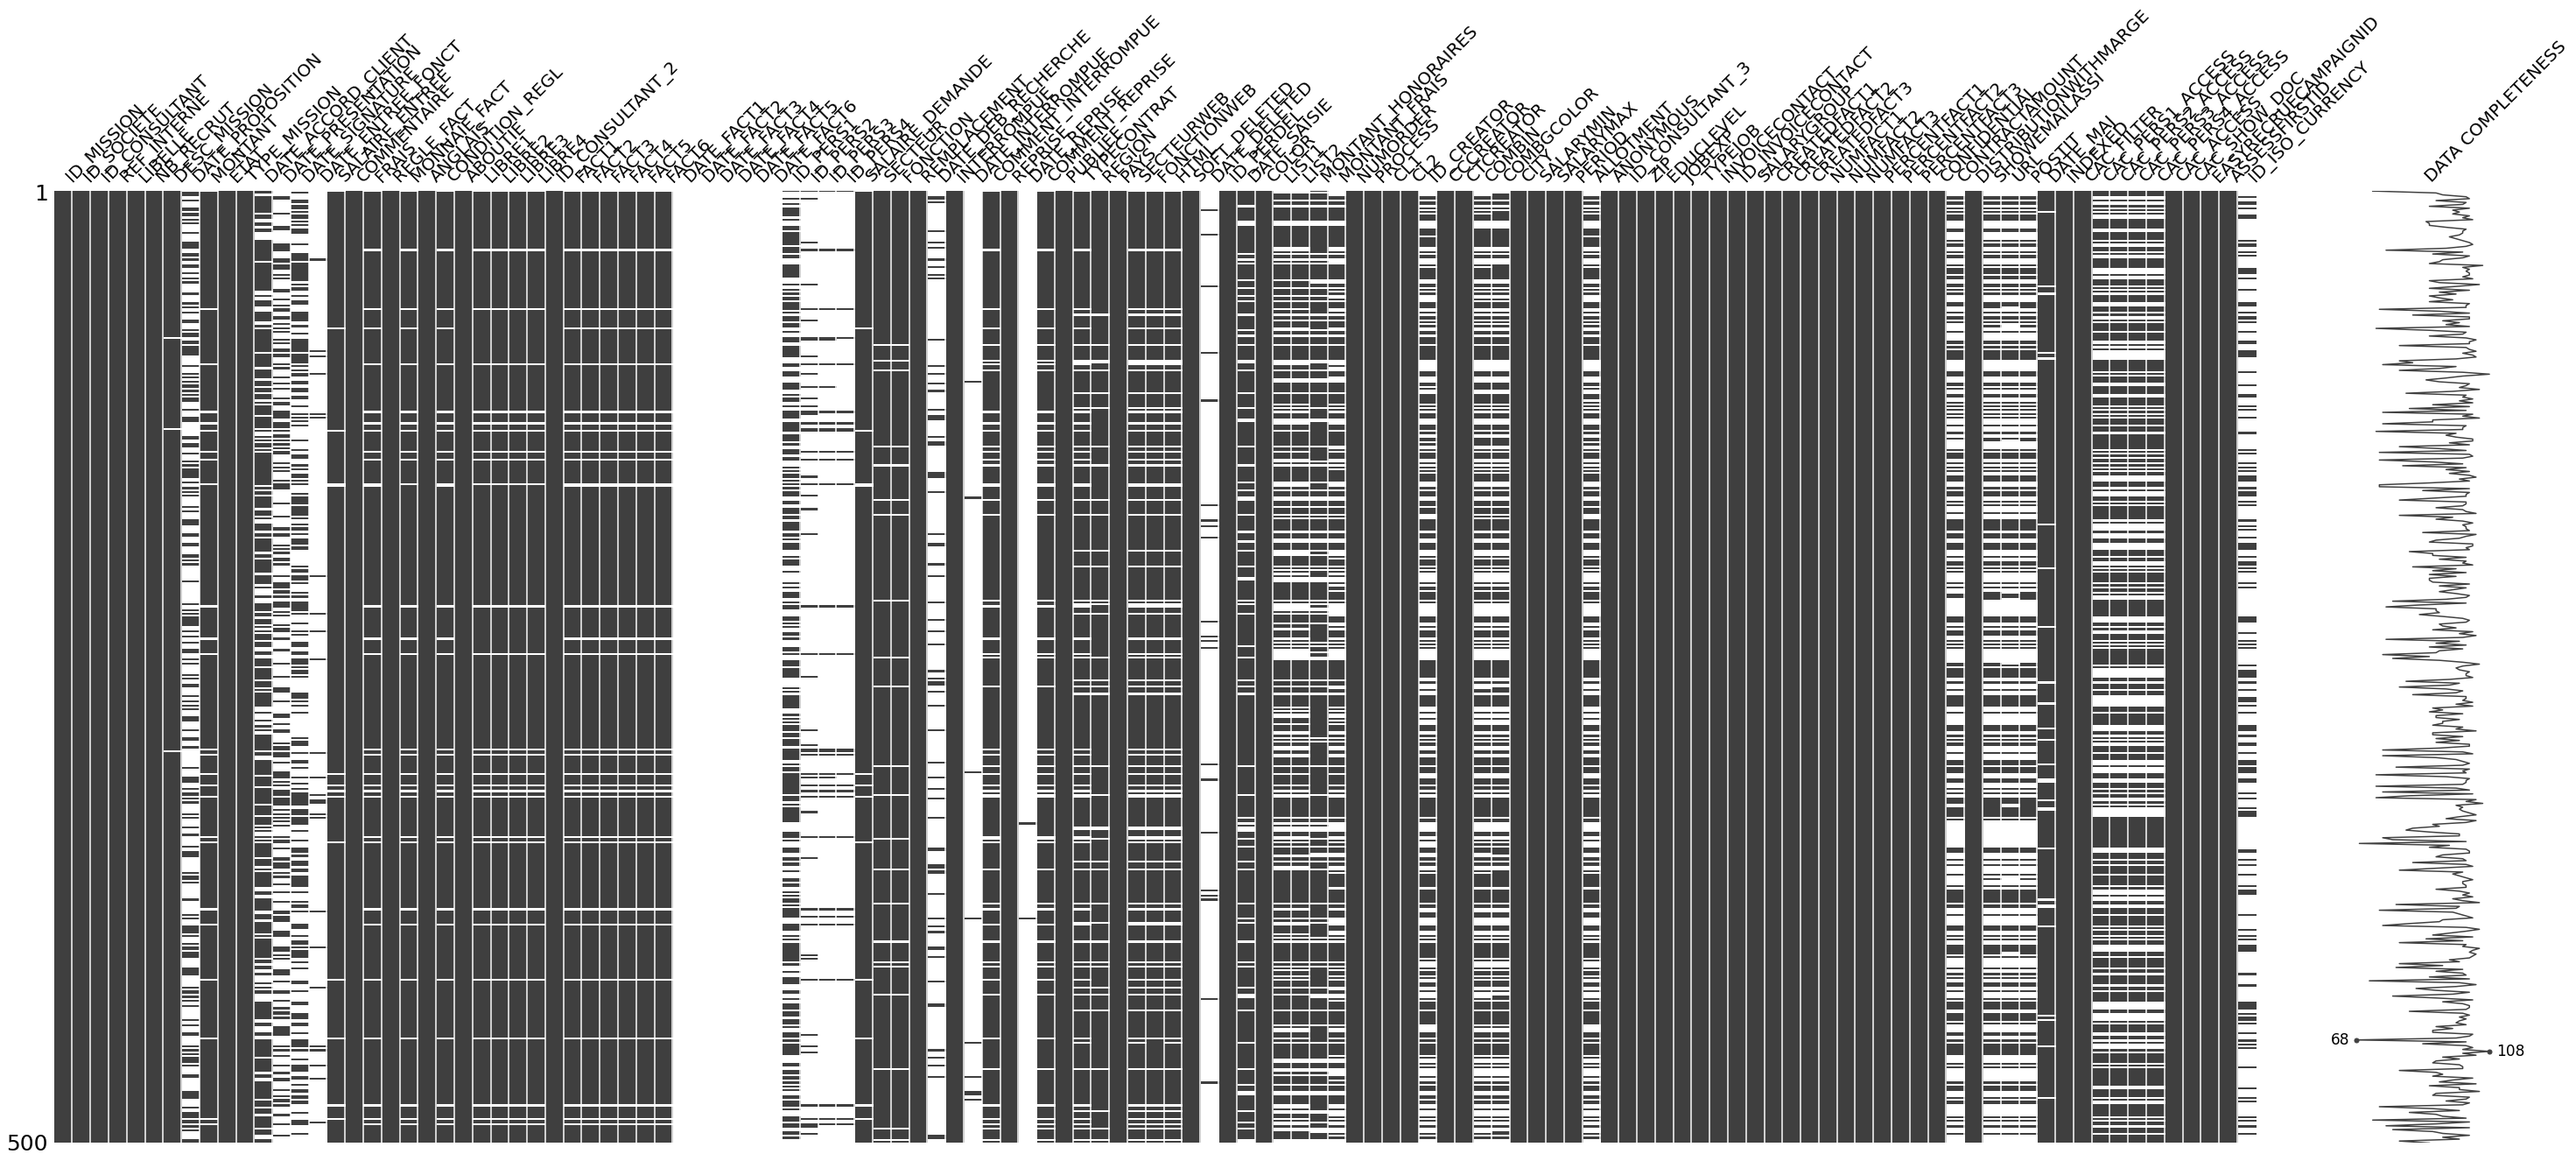

In [129]:
# Visuaisation de la distribution des valeurs nuls des données (niveau de complétude)
import missingno as msno
msno.matrix(missions.sample(500), labels=True,  figsize=(50, 20), fontsize = 20)

In [82]:
# présenter le pourcentage des valeurs NaN de maniére décroissant
# arbitrage pour supprimer les colonnes ou lignes NAN

missing_values_assessment(missions).sort_values('Manquant %', ascending=False)

Nombre d'observations: 18,944
Nombre de valeurs: 2,292,224
Valeurs manquantes: 482,199
Qualité des données: 78.96000000000001%
Type de données:
 object            61
int64             31
float64           28
datetime64[ns]     1
dtype: int64%


,Manquant,Manquant %,Type
DATE_FACT6,18944,100.00,object
DATE_FACT5,18944,100.00,object
DATE_FACT4,18944,100.00,object
DATE_FACT3,18937,99.96,object
DATE_FACT2,18934,99.95,object
...,...,...,...
ZIP,0,0.00,object
EDUCLEVEL,0,0.00,object
JOBEXP,0,0.00,object
TYPEJOB,0,0.00,object


In [97]:
# Drop duplicates
initial_length = len(missions)
missions.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(missions)))

Suppression des doublons: 0


# Etude table actions

In [90]:
# view détails table actions
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060189 entries, 0 to 3060188
Data columns (total 63 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ID_ACTION           int64          
 1   ID_TYPE_ACTION      float64        
 2   ID_PERSONNE         int64          
 3   ID_SOCIETE          int64          
 4   ID_MISSION          int64          
 5   LIB_ACTION          object         
 6   DATE_PREVUE         object         
 7   DATE_ECHEANCE       object         
 8   DATE_REALISEE       object         
 9   REALISEE            int64          
 10  ETAT                int64          
 11  PRIVEE              int64          
 12  COMMENTAIRE         object         
 13  PRIORITE            int64          
 14  AVANCEMENT          int64          
 15  ID_CONSULTANT       int64          
 16  HEURE_ACTION        timedelta64[ns]
 17  SOFT_DELETED        int64          
 18  DATE_DELETED        object         
 19  ID_PERDEL           i

In [84]:
# view premiéres lignes table actions
actions.head()

,ID_ACTION,ID_TYPE_ACTION,ID_PERSONNE,ID_SOCIETE,ID_MISSION,LIB_ACTION,DATE_PREVUE,DATE_ECHEANCE,DATE_REALISEE,REALISEE,...,ID_CONSULTANT2,POSTIT,EXTERNALCOMMENT,EXTERNALCOMBGCOLOR,INDEXED,C9,C10,N5,N6,OUTLOOK_ITEM_USER2
0,1,17.0,22,0,0,Lincoln Interview,2001-06-07,None,None,0,...,0,None,None,NaN,1,,,0,0,None
1,2,17.0,45,0,189,Lincoln Interview,2001-05-30,None,None,0,...,0,None,None,NaN,1,,,0,0,None
2,3,17.0,49,0,26,Lincoln Interview,2001-05-31,None,None,0,...,0,None,None,NaN,1,,,0,0,None
3,4,17.0,52,0,23,Lincoln Interview,2001-06-06,None,None,0,...,0,None,None,NaN,1,,,0,0,None
4,5,17.0,58,0,189,Lincoln Interview,2001-06-05,None,None,0,...,0,None,None,NaN,1,,,0,0,None


<BarContainer object of 63 artists>

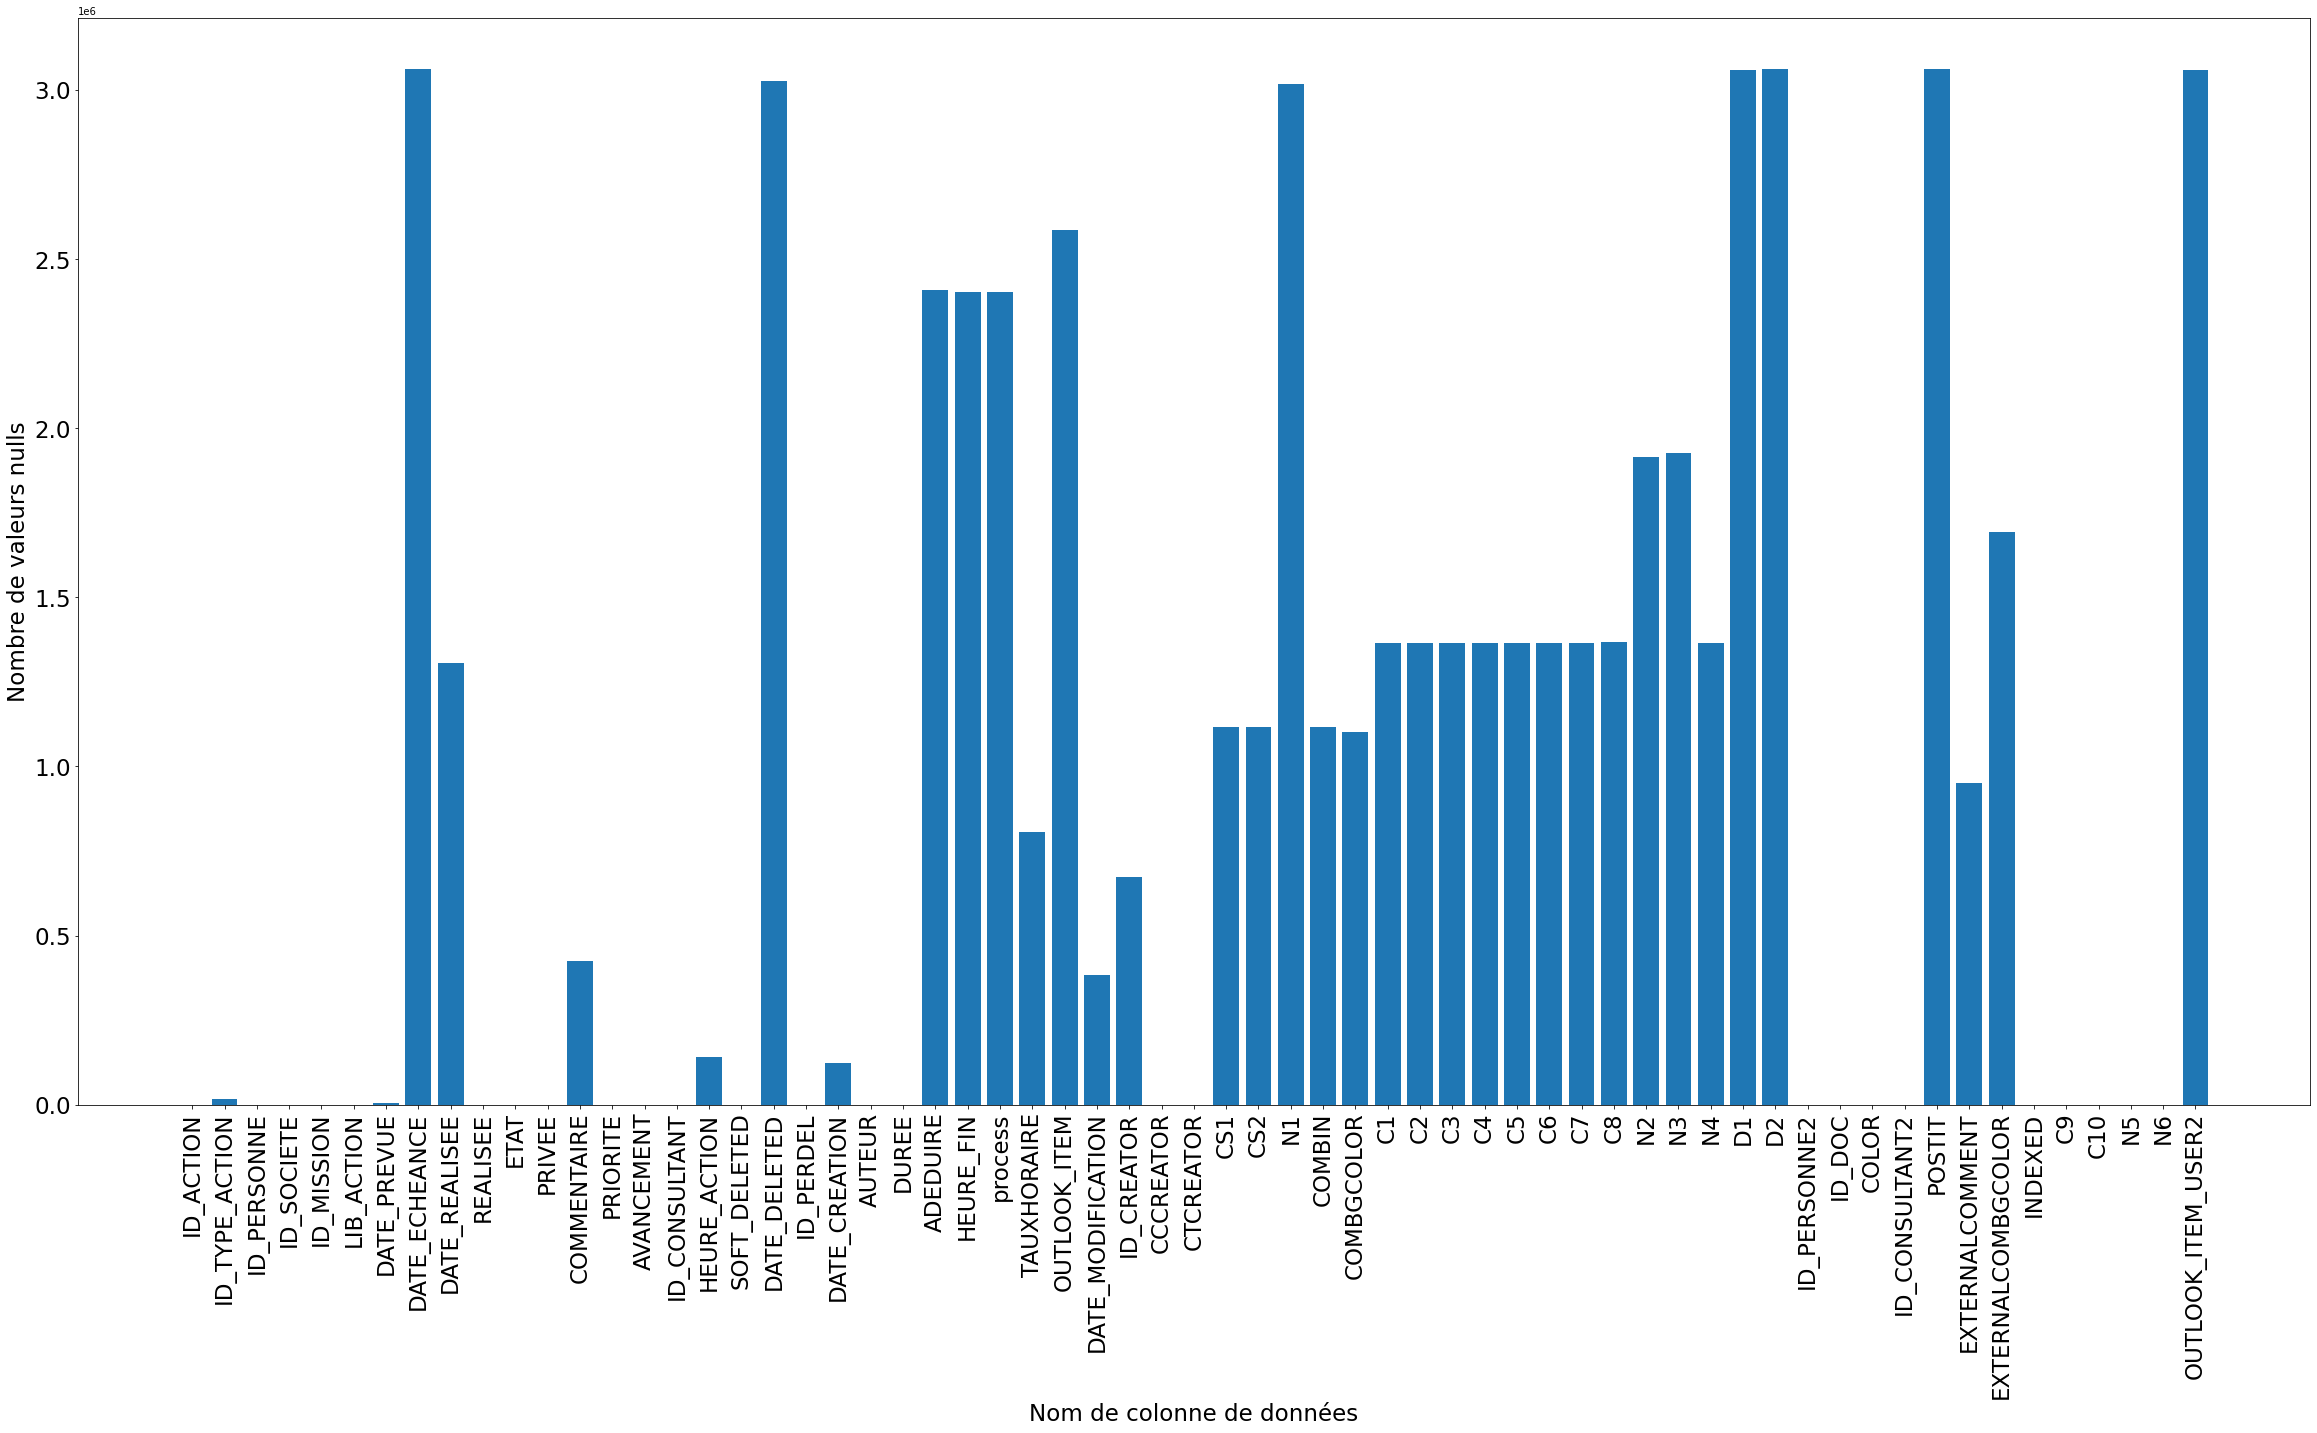

In [85]:
# Distribution des valeurs nuls par colonne (axe y x 10^6)
distribution_null = actions.isnull().sum().to_frame().reset_index().rename(columns = {'index':'colonne', 0:'Sum_valeurs_null'})
plt.figure(figsize = (40,20))
plt.xticks(rotation='vertical', fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Nom de colonne de données', fontsize = 23)
plt.ylabel('Nombre de valeurs nulls', fontsize = 23)
plt.bar(distribution_null['colonne'],distribution_null['Sum_valeurs_null'])

<AxesSubplot:>

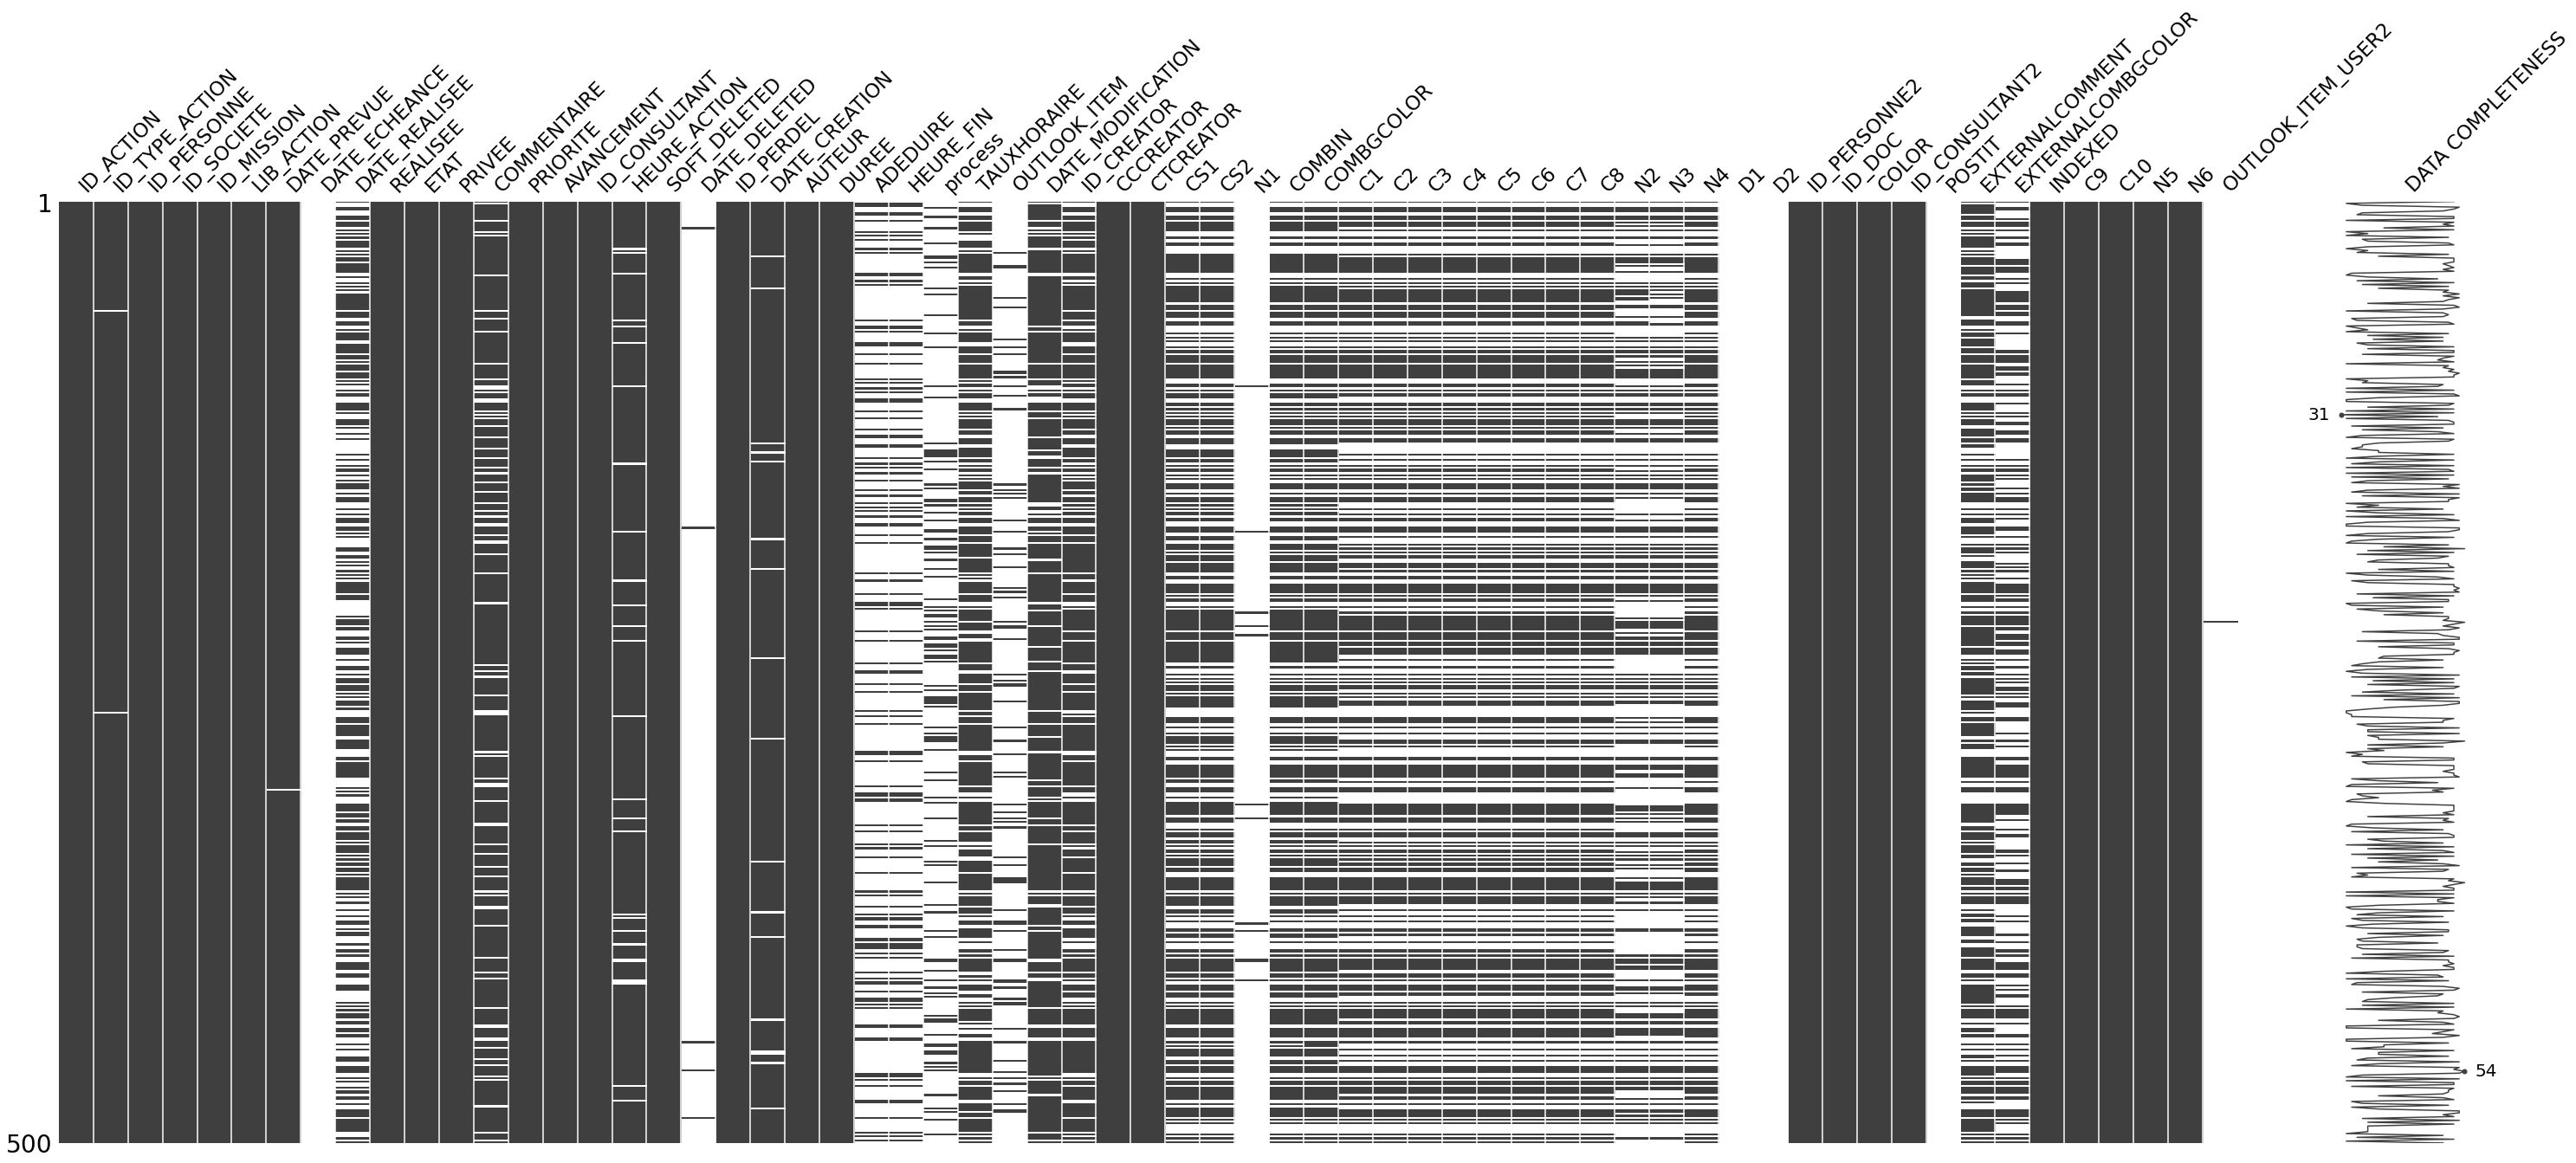

In [86]:
# Visuaisation de la distribution des valeurs nuls des données (niveau de complétude)
import missingno as msno
msno.matrix(actions.sample(500), labels=True,  figsize=(50, 20), fontsize = 23)

In [87]:
# présenter le pourcentage des valeurs NaN de maniére décroissant
# arbitrage pour supprimer les colonnes ou lignes NAN

missing_values_assessment(actions).sort_values('Manquant %', ascending=False)

Nombre d'observations: 3,060,189
Nombre de valeurs: 192,791,907
Valeurs manquantes: 58,249,342
Qualité des données: 69.78999999999999%
Type de données:
 object             29
int64              20
float64             9
timedelta64[ns]     3
datetime64[ns]      2
dtype: int64%


,Manquant,Manquant %,Type
POSTIT,3060156,100.00,object
D2,3060189,100.00,object
DATE_ECHEANCE,3059987,99.99,object
D1,3059721,99.98,object
OUTLOOK_ITEM_USER2,3058290,99.94,object
...,...,...,...
LIB_ACTION,0,0.00,object
ID_MISSION,0,0.00,int64
ID_SOCIETE,0,0.00,int64
ID_PERSONNE,0,0.00,int64


In [98]:
# Drop duplicates
initial_length = len(actions)
actions.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(actions)))

Suppression des doublons: 0


# Etude table personnes

In [89]:
# view détails table personnes
personnes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661408 entries, 0 to 661407
Columns: 145 entries, ID_PERSONNE to DATE_DISPO
dtypes: datetime64[ns](3), float64(15), int64(43), object(84)
memory usage: 731.7+ MB


In [91]:
# view premiéres lignes table personnes
personnes.head()

,ID_PERSONNE,PER_ID_PERSONNE,ID_SOCIETE,CIVILITE,NOM,PRENOM,ADRESSE,CODE_POSTAL,VILLE,TEL_DIRECT,...,EXPECTEDSALARYMAX,SKYPELOGIN,TWITTERPAGE,FACEBOOKPAGE,ID_ISO_CURRENCY,RGPD_VALIDATED,RGPD_VALIDATEDDATE,RGPD_ASKEDDATE,RGPD_DISABLED,DATE_DISPO
0,22,0,0,Mrs.,GOFFAUX,Anne,3 rue Arago,92800,Puteaux,None,...,NaN,None,None,None,None,0,None,None,1,None
1,26,0,2289,Mrs.,CASSIERE NIKALEK,Catherine,None,None,None,,...,NaN,None,None,None,None,0,None,None,0,None
2,29,0,19911,Mr.,LEGRAND,Stéphane,19 rue Pierre Lhomme,92400,Courbevoie,,...,NaN,None,None,None,None,0,None,None,0,None
3,30,0,5293,Mrs.,CORBEAU-KRISAM,Karine,18 allée Georges Récipon,75019,paris,,...,NaN,None,None,None,None,0,None,None,0,None
4,31,0,1271,Ms,DELBECQ,Stéphanie,72 boulevard National,92000,Nanterre,,...,NaN,None,None,None,None,0,None,None,0,None


<BarContainer object of 145 artists>

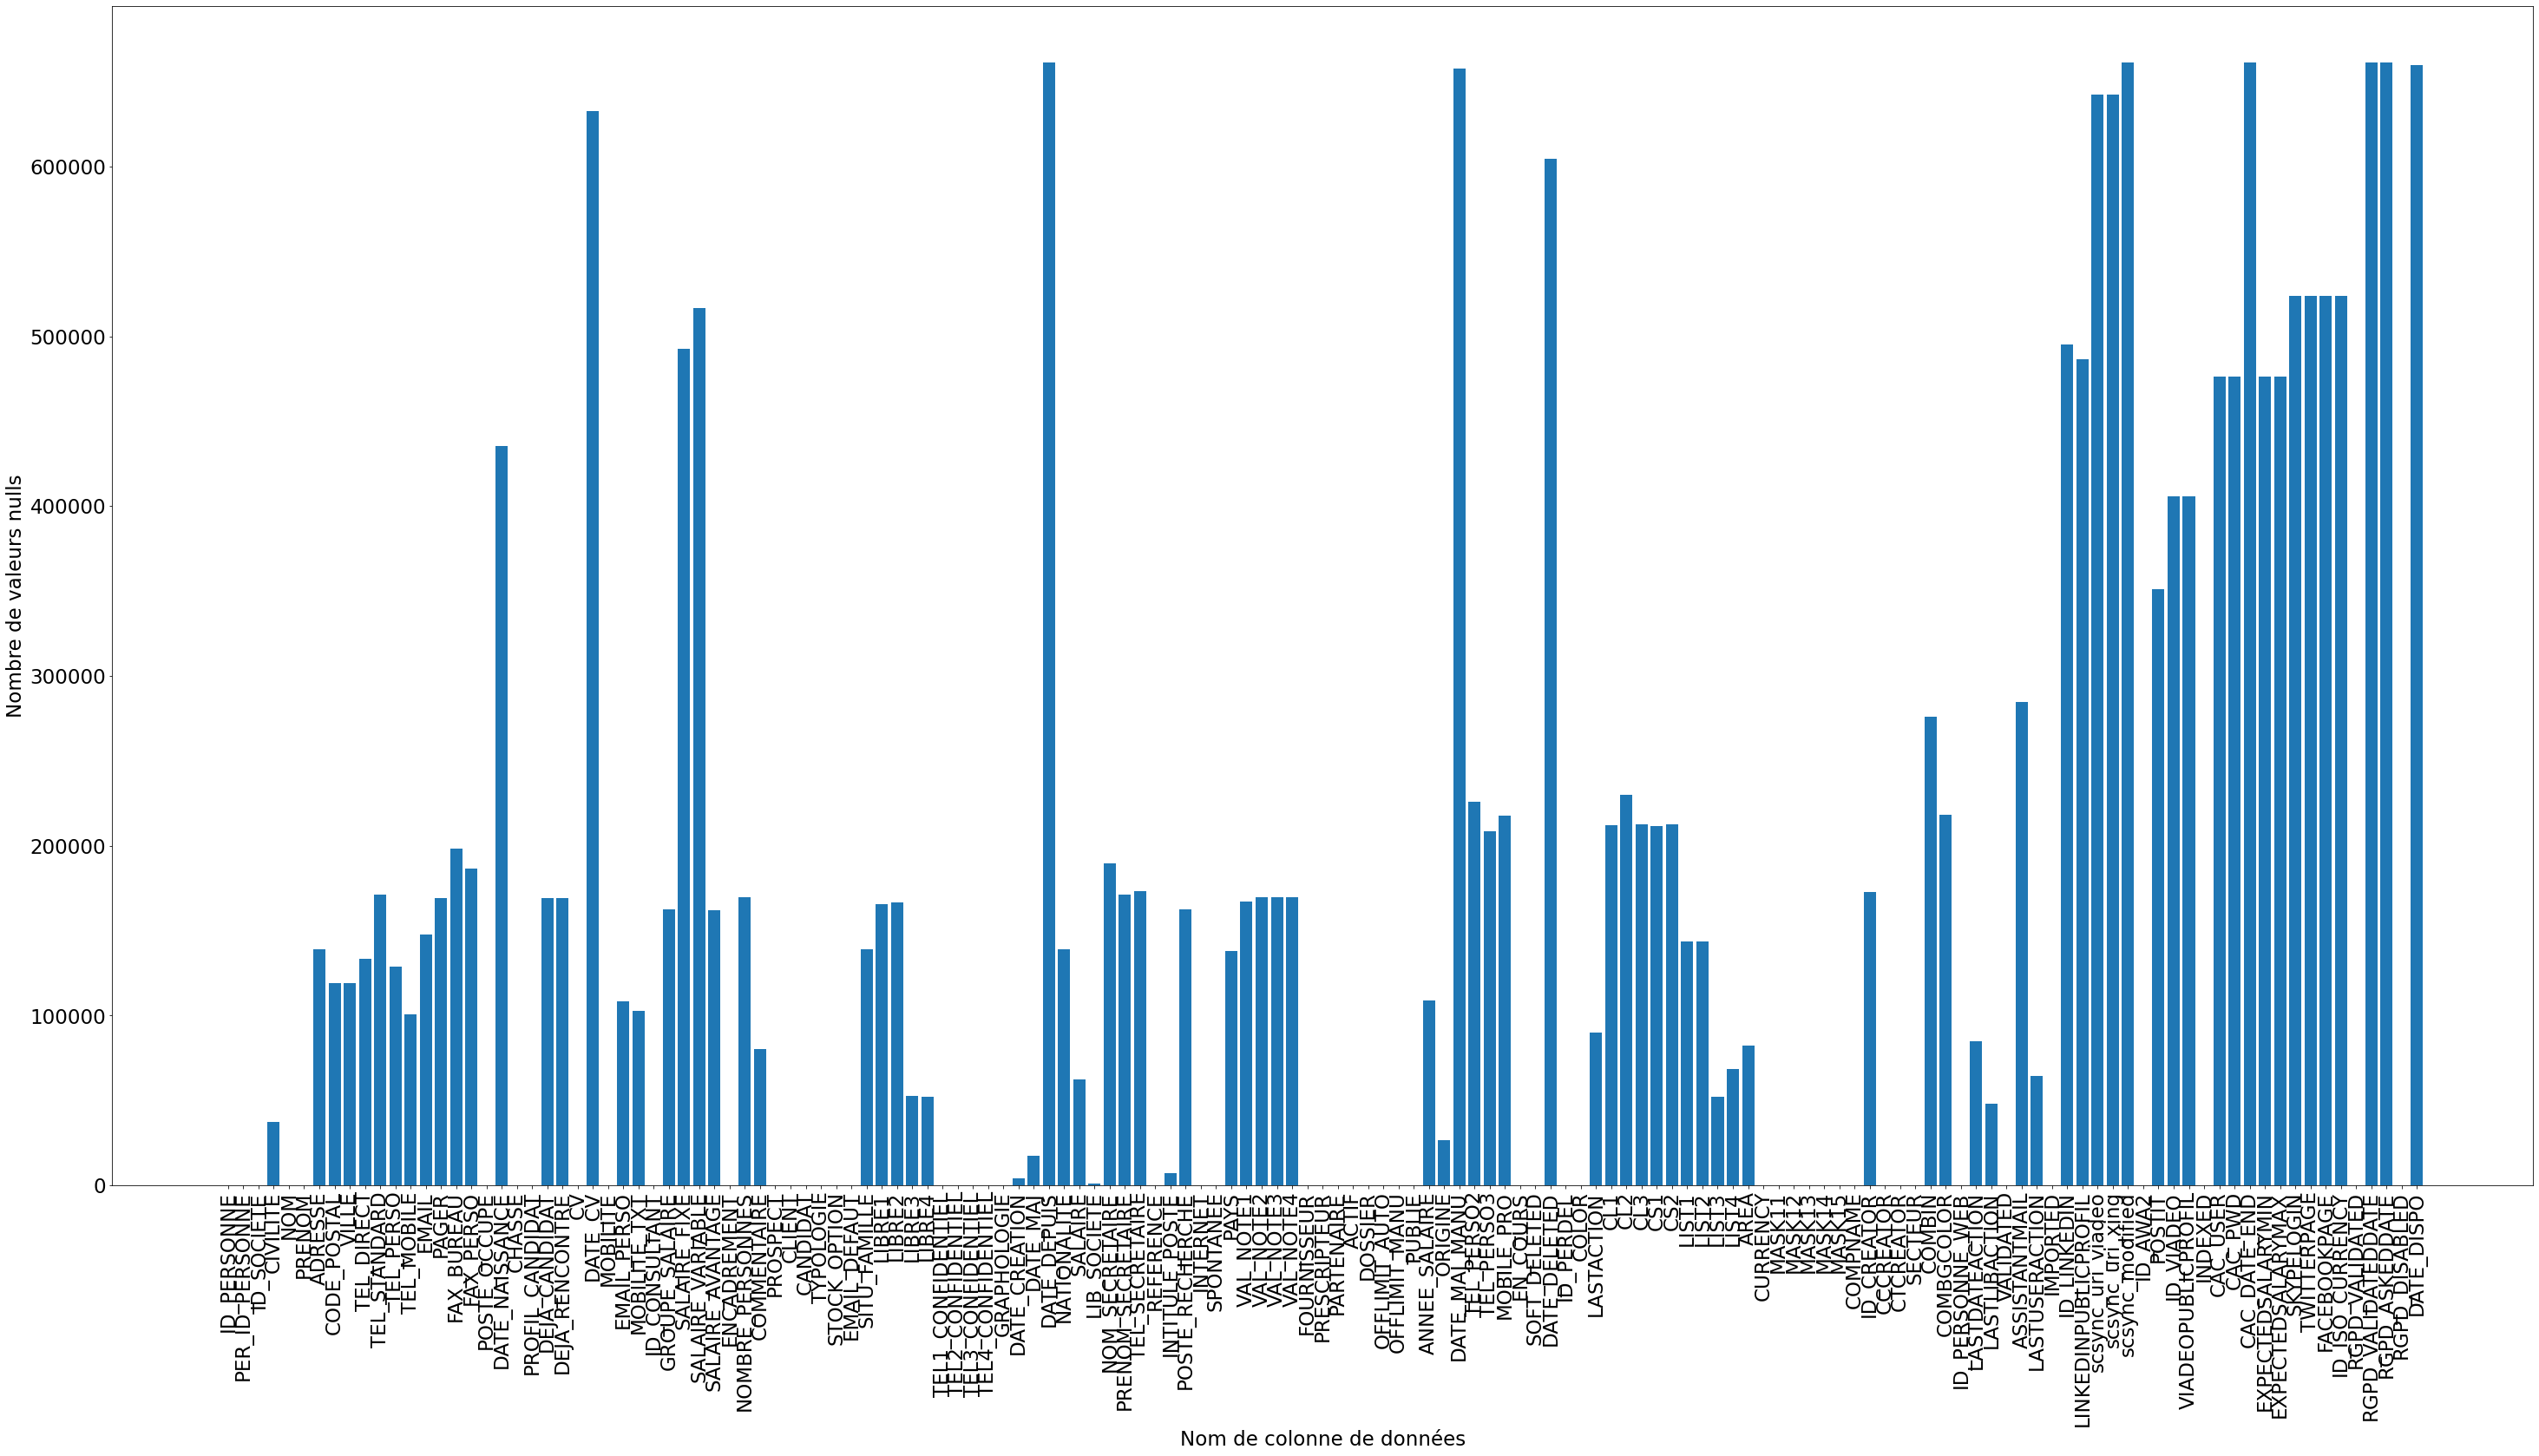

In [94]:
# Distribution des valeurs nuls par colonne
distribution_null = personnes.isnull().sum().to_frame().reset_index().rename(columns = {'index':'colonne', 0:'Sum_valeurs_null'})
plt.figure(figsize = (50,25))
plt.xticks(rotation='vertical', fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Nom de colonne de données', fontsize = 23)
plt.ylabel('Nombre de valeurs nulls', fontsize = 23)
plt.bar(distribution_null['colonne'],distribution_null['Sum_valeurs_null'])


<AxesSubplot:>

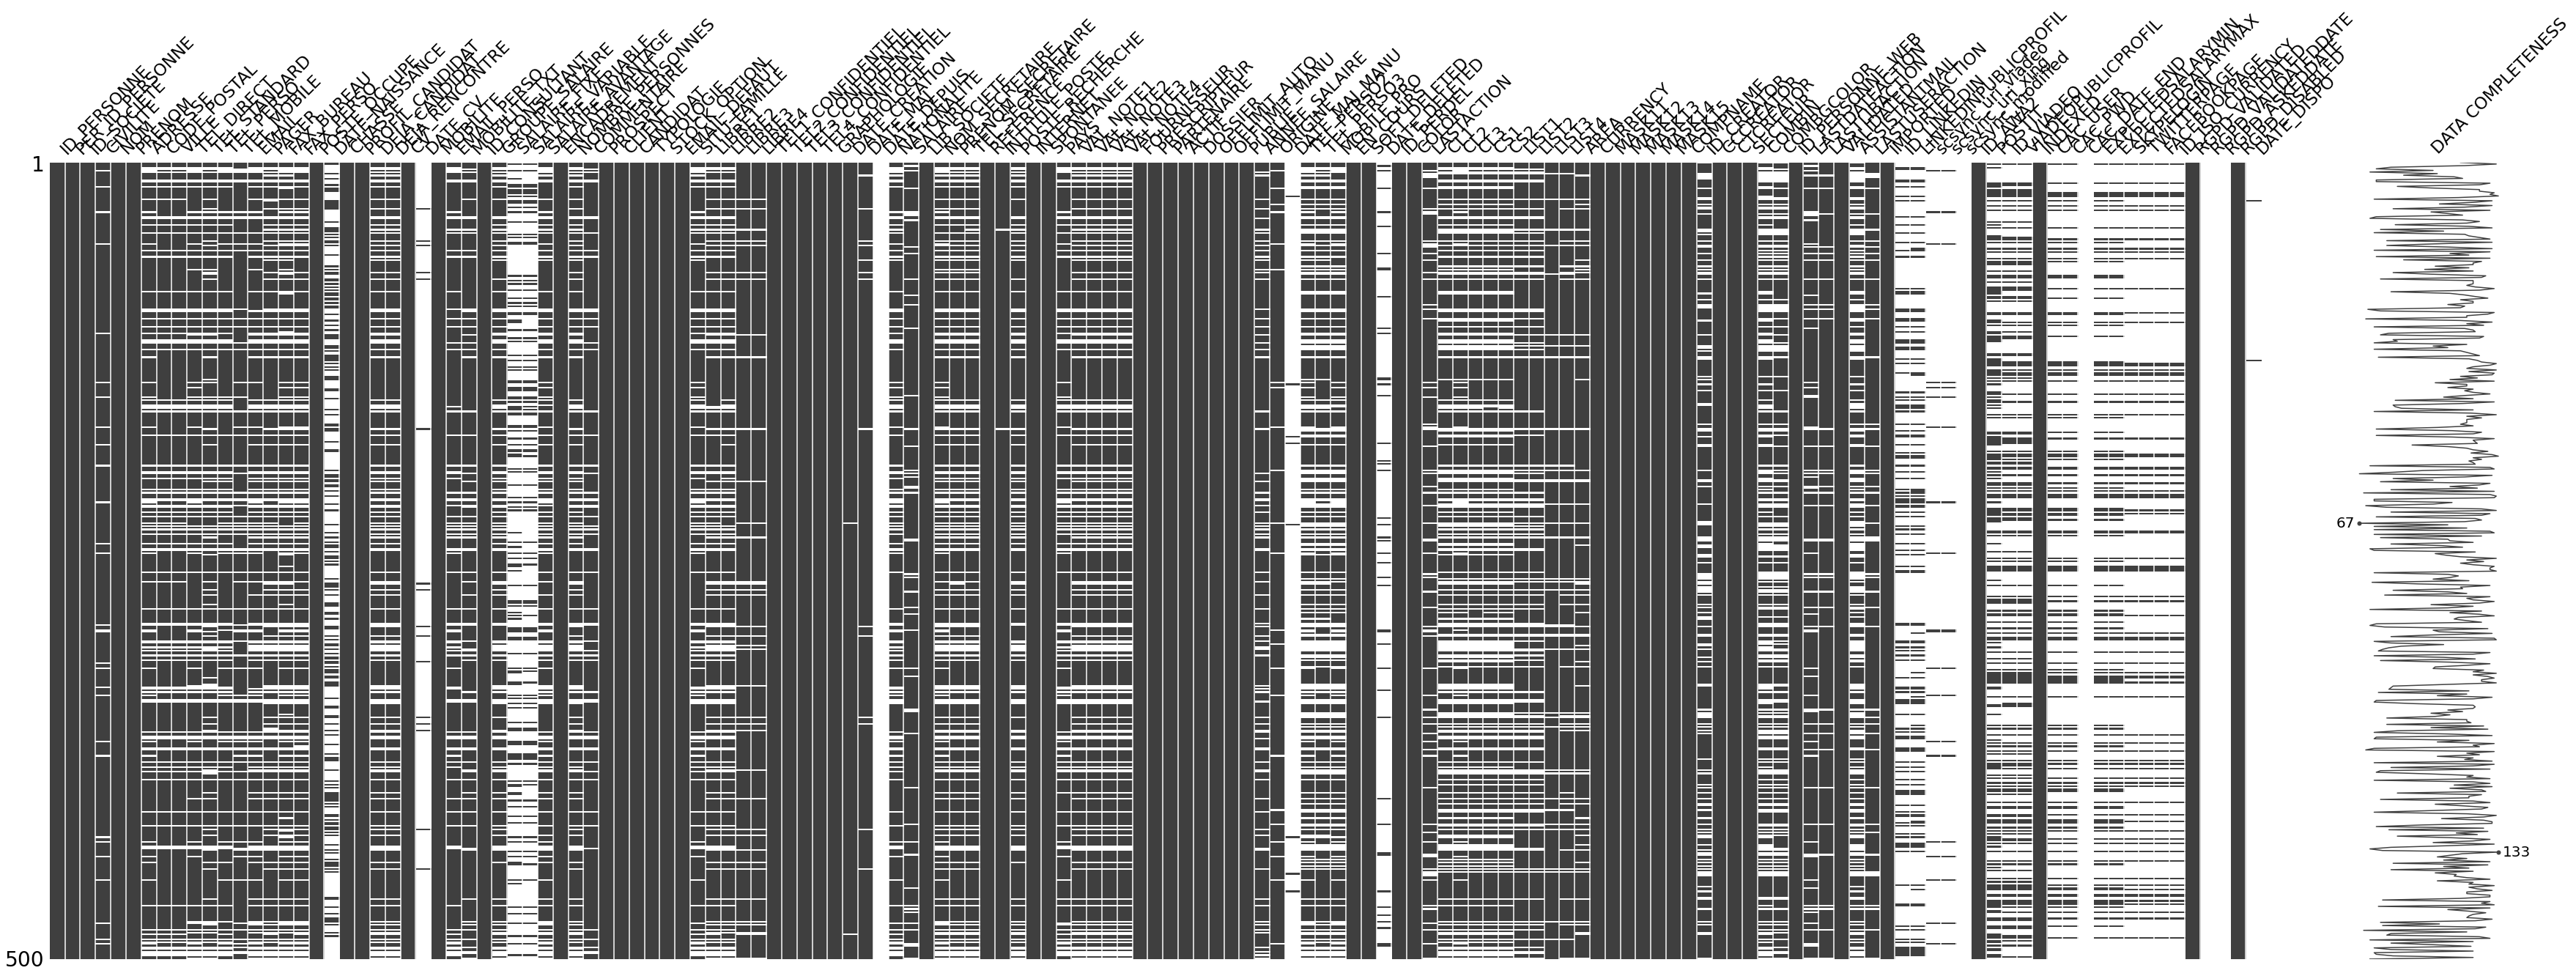

In [96]:
# Visuaisation de la distribution des valeurs nuls des données (niveau de complétude)
import missingno as msno
msno.matrix(personnes.sample(500), labels=True,  figsize=(60, 20), fontsize = 23)


In [99]:
# présenter le pourcentage des valeurs NaN de maniére décroissant
# arbitrage pour supprimer les colonnes ou lignes NAN

missing_values_assessment(personnes).sort_values('Manquant %', ascending=False)

Nombre d'observations: 661,408
Nombre de valeurs: 95,904,160
Valeurs manquantes: 23,430,966
Qualité des données: 75.57%
Type de données:
 object            84
int64             43
float64           15
datetime64[ns]     3
dtype: int64%


,Manquant,Manquant %,Type
RGPD_ASKEDDATE,661389,100.0,object
RGPD_VALIDATEDDATE,661377,100.0,object
DATE_DEPUIS,661408,100.0,object
scsync_modified,661402,100.0,datetime64[ns]
CAC_DATE_END,661407,100.0,object
...,...,...,...
PER_ID_PERSONNE,0,0.0,int64
FOURNISSEUR,0,0.0,int64
SPONTANEE,0,0.0,int64
INTERNET,0,0.0,int64


In [100]:
# Drop duplicates
initial_length = len(personnes)
personnes.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(personnes)))

Suppression des doublons: 0


In [ ]:
# Exercice SQL : chercher les candiadats concernées par l'opportunité Group HR Operation Manager chez Koramic2Engage 

In [115]:
societes_maj.head()

,ID_SOCIETE,ID_SIEGE,RAISON_SOCIALE,ADRESSE,CODE_POSTAL,VILLE,TEL,FAX,PROFIL,CODE_NAF,...,LIST2,LASTUSERACTION,NUMVAT,RAISON_SOCIALE2,AWA2COMPANYREF,CSIGN,POSTIT,DATE_MAJ,INDEXED,PAYMENT_LIMIT
0,1,0,LINCOLN,,None,None,None,None,0,,...,None,PERNOTTE Marion,None,,,,None,2021-10-18 13:47:18,1,None
1,14,0,CHEMUNEX SA,None,None,None,None,None,0,,...,None,ANCIENS CR,None,,,,None,2018-04-23 17:39:30,1,None
2,15,0,BOUYGUES TELECOM,"83, rue Henri Farman",92130,Issy Les Moulineaux,01 39 26 75 00,01 39 26 75 01,0,28,...,,DE WATRIGANT Véronique,None,BOUYGUES TELECOM,,BOUYGUES TELECOM,,2021-10-19 16:49:01,1,None
3,18,0,ACXIOM,"235, avenue le Jour se Lève",92100,BOULOGNE,None,None,0,,...,None,PUJOS Maria,None,,,,None,2018-07-05 14:36:43,1,None
4,20,0,ORANGE,"78, rue Olivier de Serres",75015,Paris,01 44 44 22 22,,0,642C,...,,BIGATA Carmen,None,ORANGE,,ORANGE,,2021-10-26 18:12:13,1,None


In [139]:
#Candidats qui sont basé en (Belgique,Lille) et leur intitulé de poste contient HR ou RH et leur secteur 
personnes[((personnes['PAYS'] == 'Belgium') | personnes['VILLE'].str.contains('Lille')) & 
          (personnes['INTITULE_POSTE'].str.contains('RH|HR|RRH')) & (personnes['SECTEUR'].str.contains('INDUSTRY|INDUSTRIE|SERVICES|REAL ESTATE|FINANCE|FINANCIAL|finance|FINANCE'))]

,ID_PERSONNE,PER_ID_PERSONNE,ID_SOCIETE,CIVILITE,NOM,PRENOM,ADRESSE,CODE_POSTAL,VILLE,TEL_DIRECT,...,EXPECTEDSALARYMAX,SKYPELOGIN,TWITTERPAGE,FACEBOOKPAGE,ID_ISO_CURRENCY,RGPD_VALIDATED,RGPD_VALIDATEDDATE,RGPD_ASKEDDATE,RGPD_DISABLED,DATE_DISPO
67691,95515,0,0,Mr.,JONET,Alain,,,,32 2 679 50 02,...,NaN,None,None,None,None,0,None,None,0,None
94889,126991,0,23582,Mr.,LO MONACO,Olivier,16 Rue de Puebla,59800,Lille,,...,NaN,None,None,None,None,0,None,None,0,None
113668,146155,0,0,Mr.,HEBBINCKUYS,Pierre-Yves,,59000,Lille,,...,NaN,None,None,None,None,0,None,None,0,None
114316,146815,0,0,Mr.,FROISSART,Loreleï,,59000,Lille,,...,NaN,None,None,None,None,0,None,None,0,None
193246,968974,0,0,Mr.,MOULIN,Alain,177 rue nationale,59800,Lille,,...,NaN,None,None,None,None,0,None,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542928,1318783,0,73531,Mme,SABATTIER,Yolande,,,,None,...,0.0,,,,,0,None,None,0,2019-11-18
560046,1335901,0,65791,None,GOVAERT,Caroline,,,,093818774,...,0.0,,,,,0,None,None,0,None
563066,1338921,0,77797,Mrs.,LAENEN,Annelies,,,,,...,0.0,,,,,0,None,None,0,None
563068,1338923,0,77797,Mrs.,VERHEGGHE,Julie,,,,,...,0.0,,,,,0,None,None,0,None
